# Estimating the Economic Value of Landslide Regulation by Forests

Advanced Geocomputation

Matt Braaksma (University of Minnesota)

## Project Description

This project integrates multiple data sources to estimate the economic
value of landslide regulation by forests. The final result is the
estimated number of avoided deaths at the ADM 3 regional level. The data
sources have global coverage, but for now the project scope is limited
to Nepal, as a proof of concept.

### Ecosystem Services

Ecosystem services, like landslide regulation by forests, provide
crucial benefits that are often not directly reflected in the market,
making them difficult to value. Understanding these services is key for
informed policy decisions.

<figure>
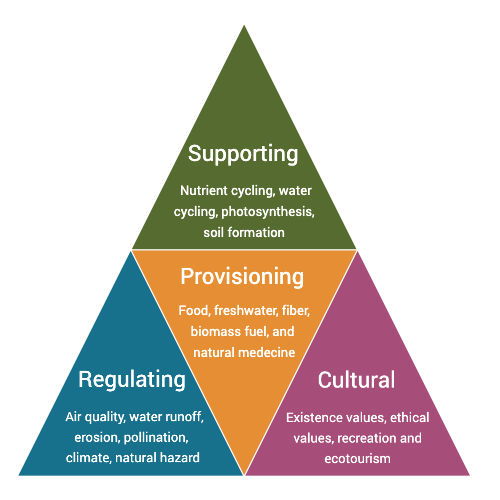
<figcaption aria-hidden="true">source: <a
href="https://www.earthwiseaware.org/what-are-ecosystem-services/"
class="uri">https://www.earthwiseaware.org/what-are-ecosystem-services/</a></figcaption>
</figure>

### Landslide Regulation

-   Landslides cause significant damage (including human casualties)
    globally
    -   Especially in mountainous regions
-   Forests (and other vegetation) help mitigate landslide risks by
    stabilizing soil and absorbing rainfall
    -   This service is clearly valuable, but difficult to quantify
    -   Key to policy decisions to consider costs and benefits

### Project Methodological Framework

The framework is largely inspired by Brander et al. 2018, which focused
on households in Georgia.

1.  Estimate Mortality Function
    -   Historical Landslide Deaths
    -   Sediment Export
        1.  Actual
        2.  Counterfactual (Forest Cover converted to Bare)
    -   Population Data
2.  Use Predicted Mortality to Estimate Economic Value
    -   Avoided deaths = Predicted Counterfactual Deaths - Actual Deaths
    -   Value of a Statistical Life (VSL) to estimate economic value

### Historical Landslide Death Data

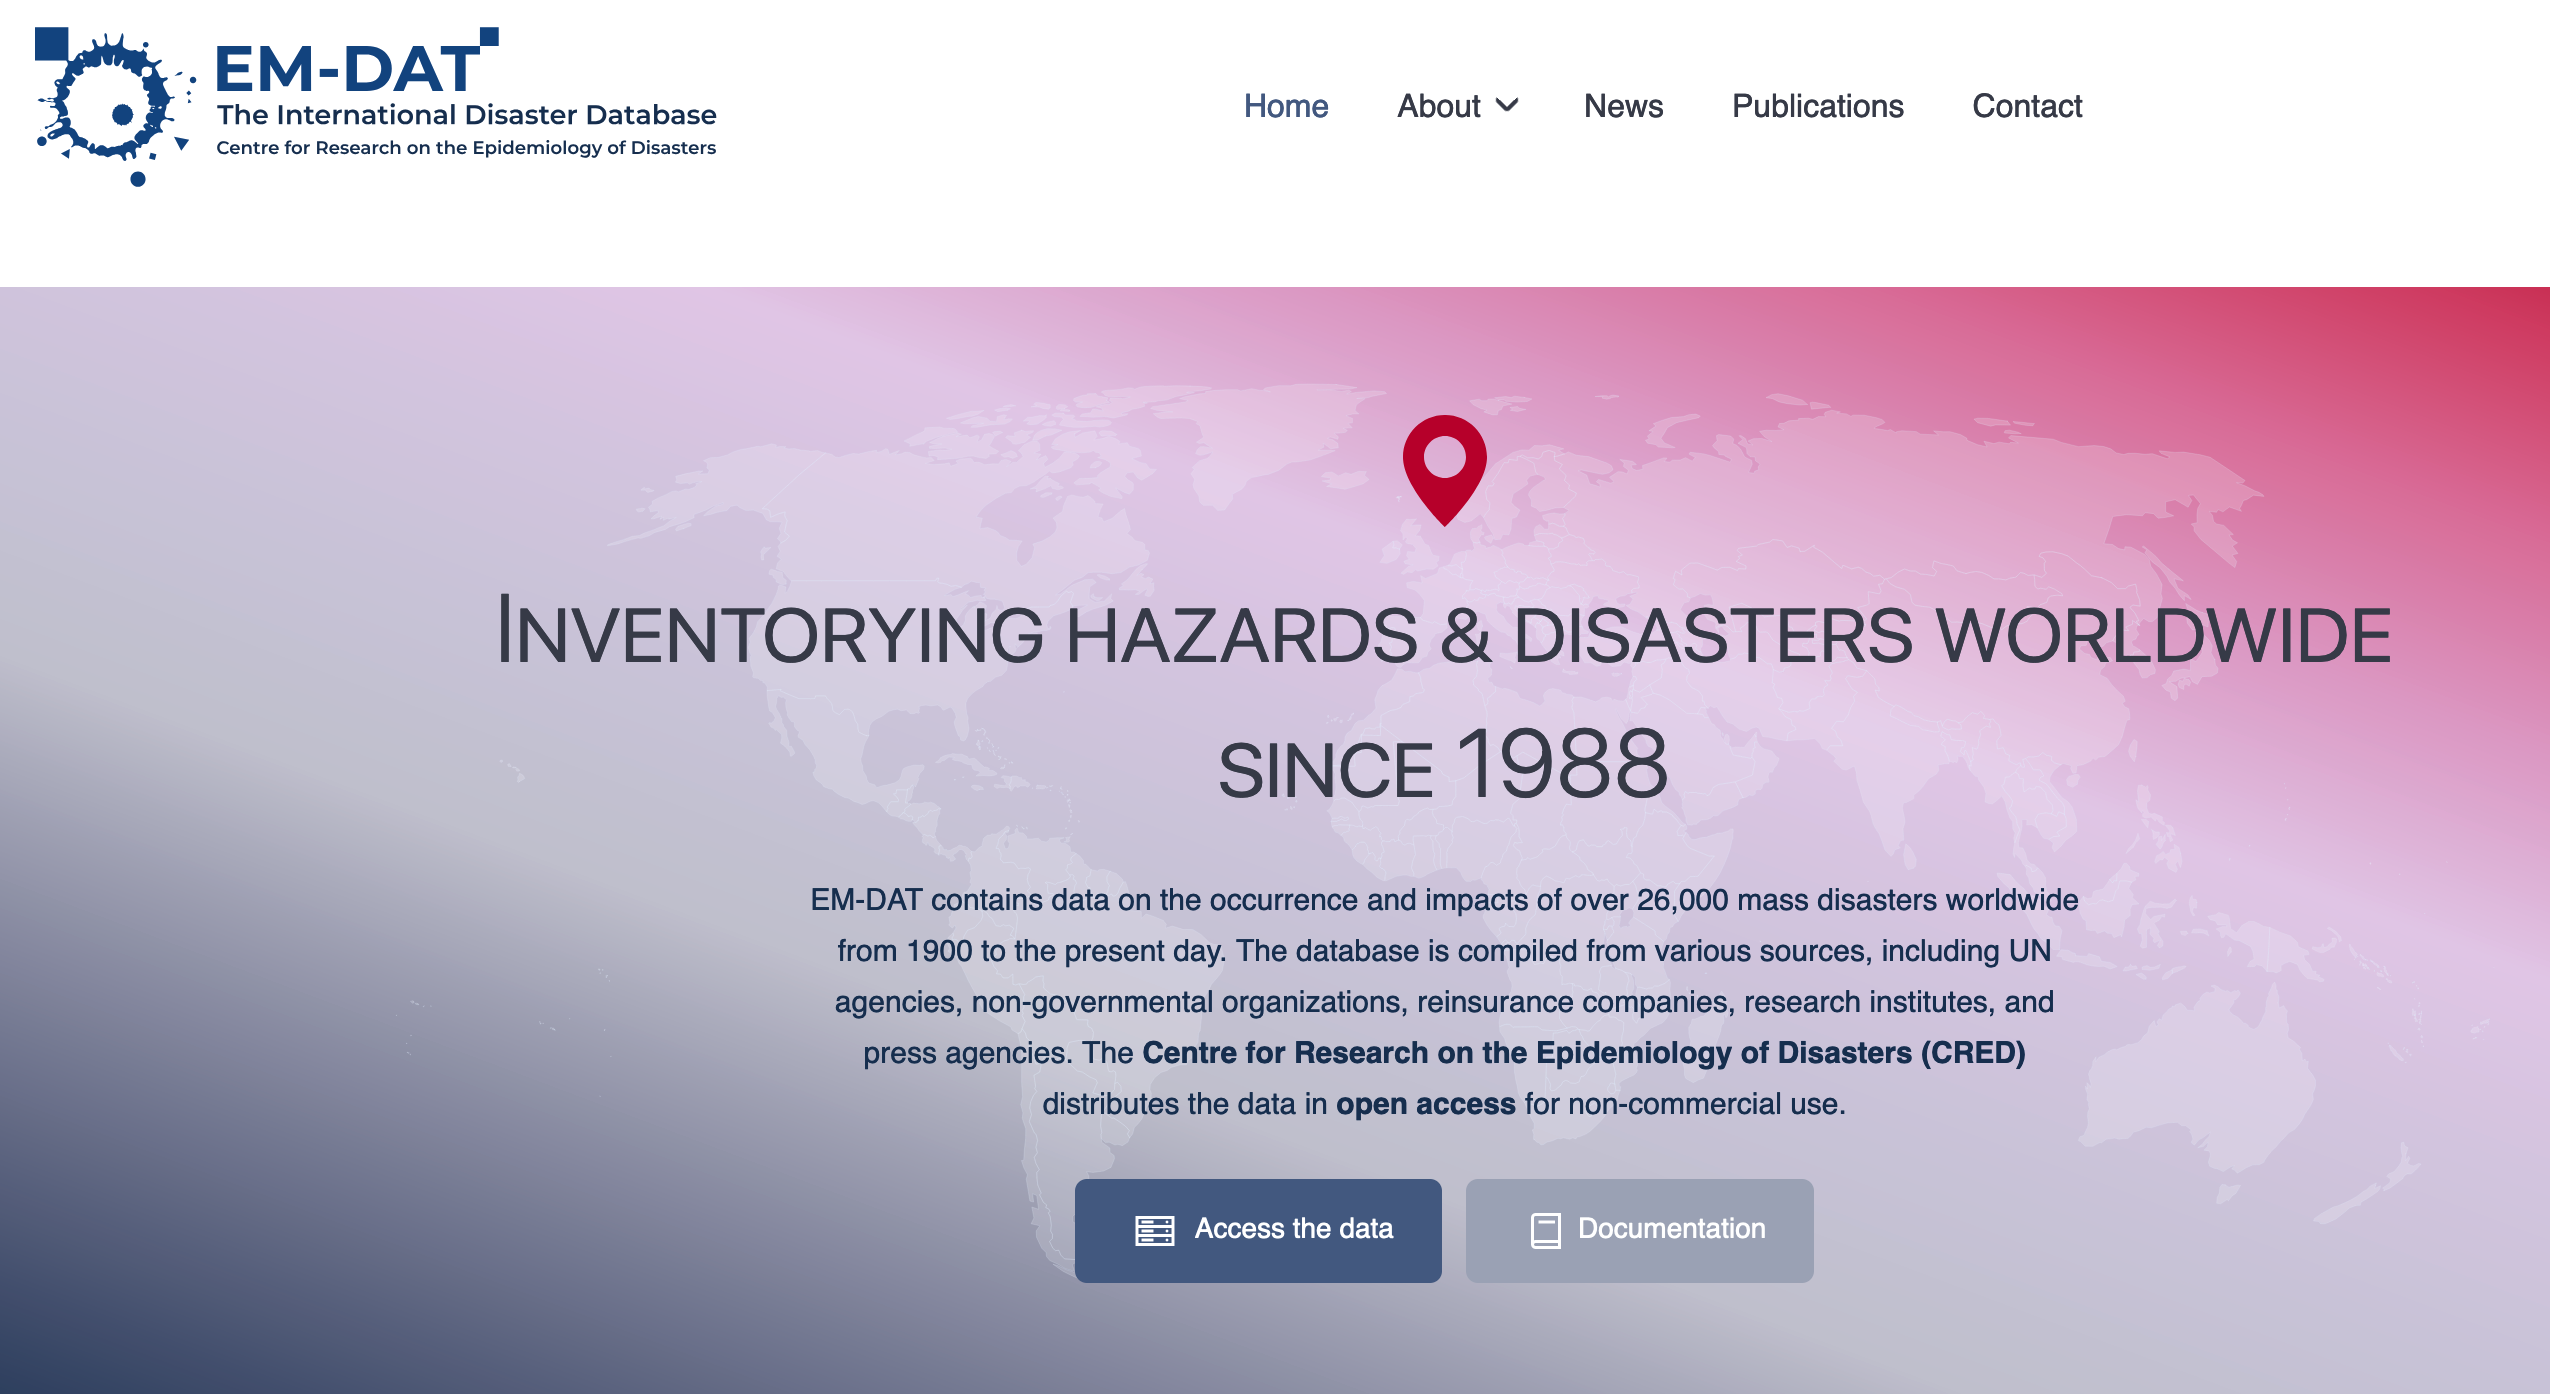

### Sediment Export Data

***InVEST SDR Model***

To estimate sediment export, I use the InVEST SDR model, which applies
the Revised Universal Soil Loss Equation (USLE) for erosion estimation,
followed by calculating how much of the eroded soil actually reaches
streams (Sediment Delivery Ratio, or SDR).

1.  Estimation of soil erosion using the Revised Universal Soil Loss
    Equation (USLE)
    -   Maps soil loss on each pixel based on:
        -   Slope length and steepness (LS factor)
        -   Rainfall erosivity (R factor)
        -   Soil erodibility (K Factor)
        -   Vegetation Cover (C factor)
        -   Conservation practices (P factor)
    -   USLE = LS x R x K x C x P = annual erosion
2.  Estimation of the Sediment Delivery Ratio (SDR)
    -   For each pixel, calculates how much erosion actually reaches
        streams
    -   Based on land cover and degree of hydrological connectivity
    -   Sediment export = USLE x SDR

<figure>
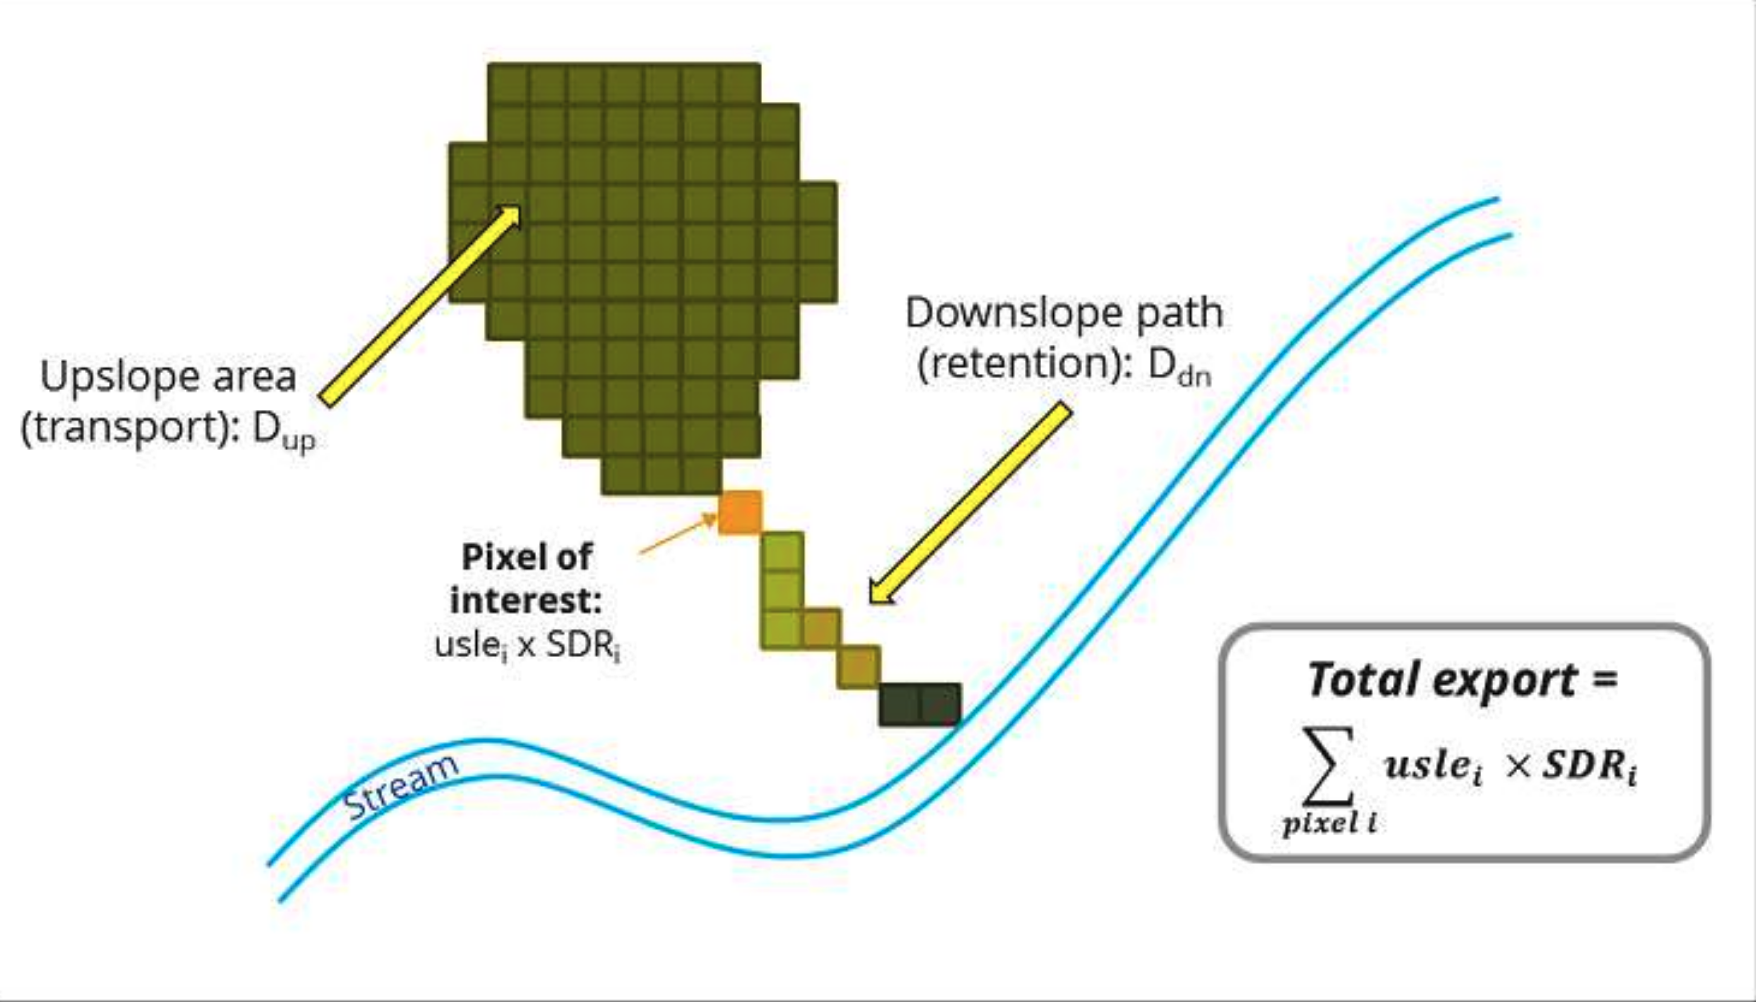
<figcaption aria-hidden="true">Sharp et al., 2020</figcaption>
</figure>

-   Input Data:

    -   Digital elevation model (DEM)
    -   Rainfall erosivity raster
    -   Soil Erodibility Raster
    -   Land use/land cover raster
    -   Watersheds shapefile
    -   Biophysical table to assign C and P factor
    -   Values to different LULC classes

### Population Data

The number of deaths caused by landslides is inherently linked to
population density. Areas with higher population densities are more
likely to experience greater casualties when landslides occur. To
account for this factor, I use NASA’s GPW (Gridded Population of the
World) dataset, providing population estimates at a high spatial
resolution.

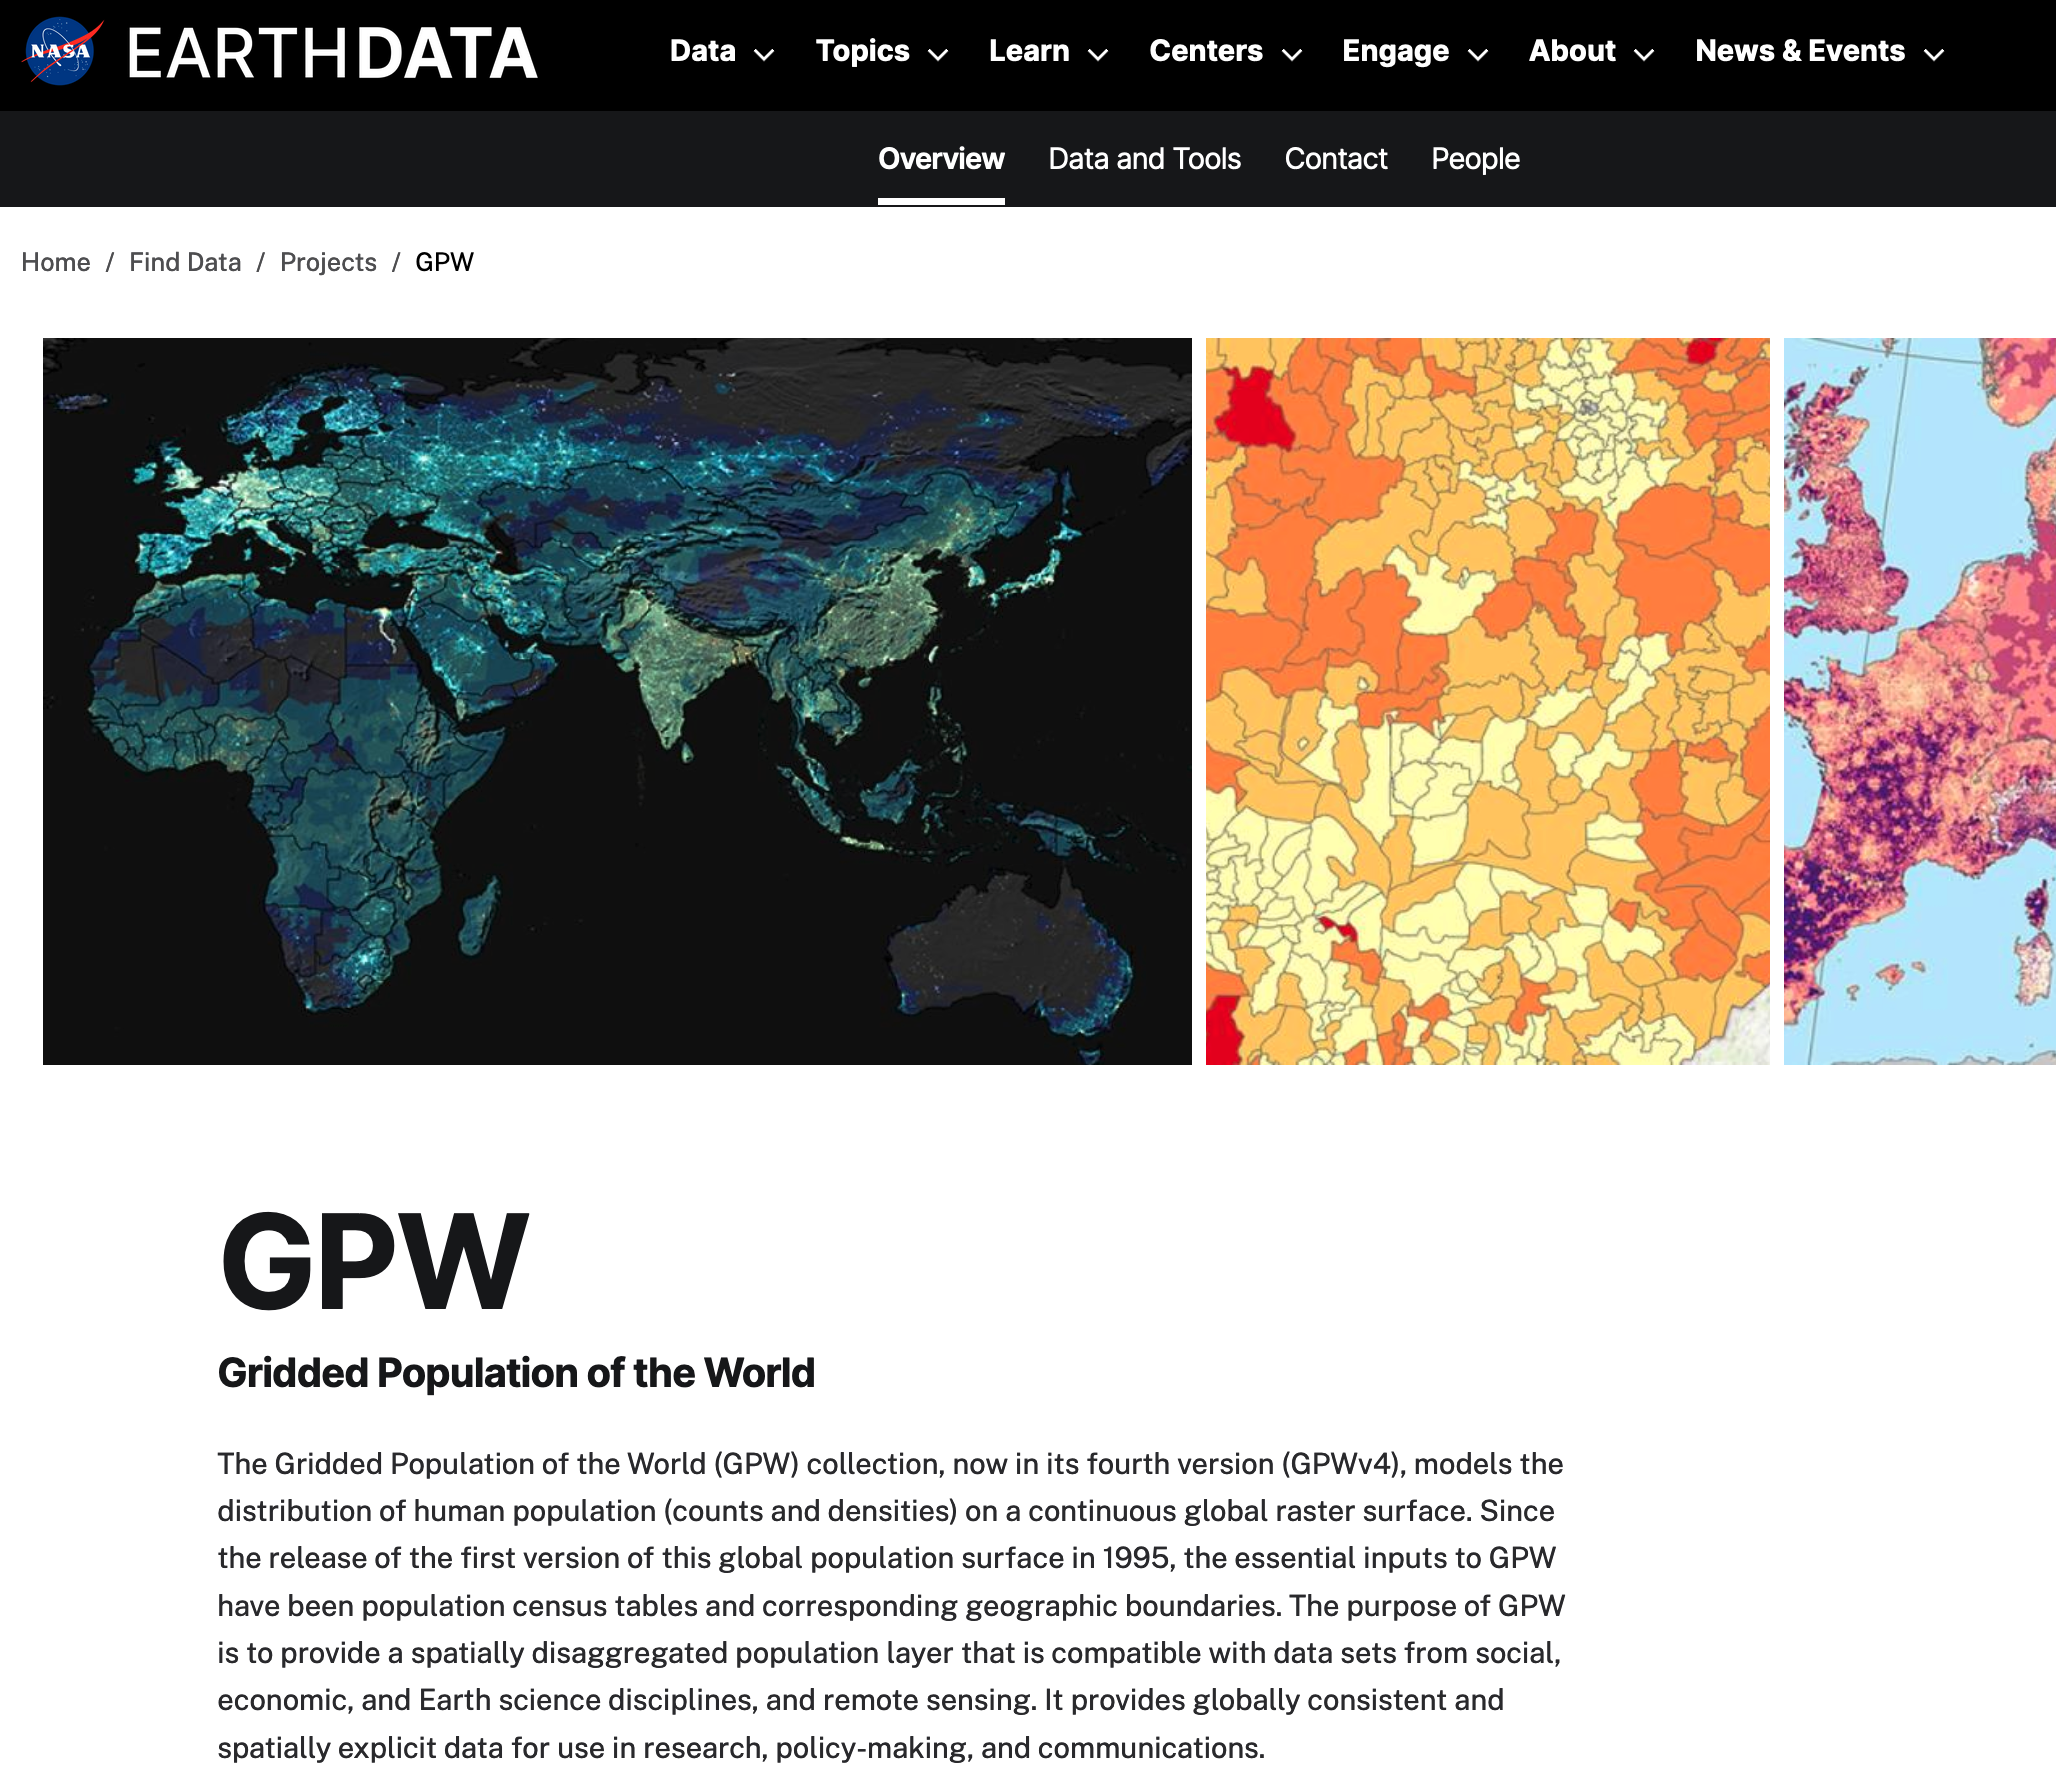

## Code

### ***Preliminary***

### Import modules

Import the necessary data, geospatial, visualization, and statistical
modules.

In [1]:
# Standard Library Imports
import os
import platform
import sys
import numpy as np
import pandas as pd

# Geospatial Data Imports
import geopandas as gpd
from rasterstats import zonal_stats
from osgeo import gdal, ogr
import pygeoprocessing
import natcap.invest.sdr.sdr

# Visualization Imports
import matplotlib.pyplot as plt

# Statistical Imports
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Directories and paths
user_dir = os.path.expanduser('~')
data_dir = os.path.join(user_dir, 'Files', 'base_data', 'gep', 'landslides')
cur_dir = os.path.join(user_dir, 'Files', 'gep_landslides')

# System Information
print("=== System Information ===")
print(f"Operating System: {platform.system()}")
print(f"OS Version: {platform.version()}")
print(f"Machine: {platform.machine()}")
print(f"Processor: {platform.processor()}")
print(f"Python Version: {sys.version}")

=== System Information ===
Operating System: Darwin
OS Version: Darwin Kernel Version 22.6.0: Mon Apr 22 20:51:27 PDT 2024; root:xnu-8796.141.3.705.2~1/RELEASE_ARM64_T6020
Machine: arm64
Processor: arm
Python Version: 3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:37:07) [Clang 15.0.7 ]

### ***Landslide Data***

### Import EMDAT (Historical Natural Disaster Database)

In [2]:
# Import data
emdat_path = os.path.join(data_dir, 'emdat','public_emdat_2024-09-09.xlsx')
emdat = pd.read_excel(emdat_path)

# Subset data to landslides
emdat[emdat['Disaster Type']=='Mass movement (wet)']['Disaster Subtype'].value_counts()
landslide_condition = (emdat['Disaster Type'] == 'Mass movement (wet)') & ((emdat['Disaster Subtype']=='Landslide (wet)') | (emdat['Disaster Subtype']=='Mudslide'))
emdat_landslides = emdat[landslide_condition]
emdat_landslides = emdat_landslides.dropna(subset=['Total Deaths'])

# Separate location data
disasterlocations_path = os.path.join(data_dir, 'pend-gdis-1960-2018-disasterlocations-gpkg', 'pend-gdis-1960-2018-disasterlocations.gpkg')
disasterlocations = gpd.read_file(
    disasterlocations_path,
    where="disastertype = 'landslide' AND level = '3'",
    engine='pyogrio'
)
disasterlocations = disasterlocations[disasterlocations['location'] != 'Okhaldunga District'] # drop duplicate

emdat['disasterno'] = emdat['DisNo.'].str.extract(r'(\d{4}-\d{4})')
emdat_gdf = disasterlocations.merge(emdat, on='disasterno', how='left')

### Import polygons for areas with no natural disasters in EMDAT

In [3]:
# Extract unique 'iso3' values
unique_country = emdat_gdf['country'].unique()

# Format the 'where' clause for SQL query
country_filter = " OR ".join([f"COUNTRY = '{country}'" for country in unique_country])

# Read the vector file using the dynamically generated 'where' clause
gadm_path = os.path.join(user_dir, 'Files', 'base_data', 'cartographic', 'gadm', 'gadm_410-levels.gpkg')
borders_gdf = gpd.read_file(
    gadm_path,
    where=country_filter,
    engine='pyogrio',
    layer='ADM_3'
)

# Check number of countries match 
emdat_countries = emdat_gdf['country'].unique()
borders_countries = borders_gdf['COUNTRY'].unique()
assert set(emdat_countries) == set(borders_countries)

### Subset to Nepal

In [4]:
## Merge and keep Nepal for test case
emdat_nepal = emdat_gdf[emdat_gdf['country'] == 'Nepal']
border_nepal = borders_gdf[borders_gdf['COUNTRY'] == 'Nepal']

emdat_nepal_adm3 = emdat_nepal.merge(border_nepal, how='right', left_on='adm3', right_on='NAME_3')
emdat_nepal_adm3 = emdat_nepal_adm3.drop(columns=['geometry_x'])
emdat_nepal_adm3 = gpd.GeoDataFrame(emdat_nepal_adm3, geometry='geometry_y')

### Aggregate ‘Total Deaths’ by ADM3 region and year

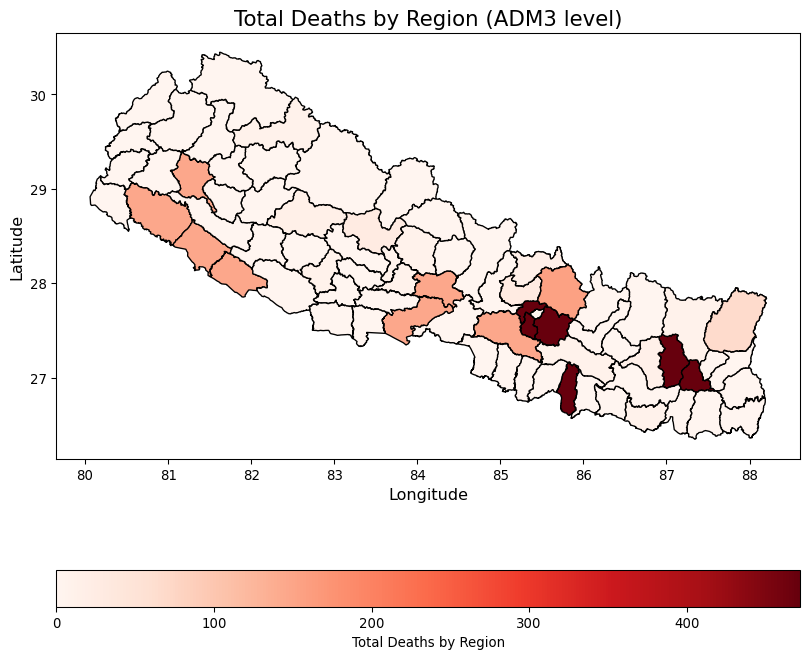

In [5]:
# Collapse to adm3 level and sum Total Deaths
emdat_nepal_adm3_agg = emdat_nepal_adm3.groupby(['adm3','Start Year']).agg({'Total Deaths': 'sum'}).reset_index()

# Merge with border_nepal to get geometries (perform a left join to keep all border_nepal regions)
emdat_nepal_adm3_merged = border_nepal.merge(emdat_nepal_adm3_agg, how='left', left_on='NAME_3', right_on='adm3')

# Fill missing Total Deaths with 0
emdat_nepal_adm3_merged['Total Deaths'] = emdat_nepal_adm3_merged['Total Deaths'].fillna(0)

# Plot the resulting data
fig, ax = plt.subplots(figsize=(10, 10))
emdat_nepal_adm3_merged.plot(column='Total Deaths', ax=ax, legend=True,
                             legend_kwds={'label': "Total Deaths by Region",
                                          'orientation': "horizontal"},
                             edgecolor='black', cmap='Reds')
ax.set_title("Total Deaths by Region (ADM3 level)", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)
plt.show()

### Expand EMDAT data to create balanced panel

In [6]:
# Generate all possible GID_3-year combinations
all_gid_3 = emdat_nepal_adm3_merged['GID_3'].unique()
all_years = range(2000, 2021)
all_combinations = pd.MultiIndex.from_product([all_gid_3, all_years], names=['GID_3', 'year'])

# Convert to a DataFrame
expanded_panel = pd.DataFrame(index=all_combinations).reset_index()

# Merge with the original data
emdat_panel = expanded_panel.merge(emdat_nepal_adm3_merged, on='GID_3', how='left')

# Fill missing values for 'Total Deaths' with 0
emdat_panel['Total Deaths'] = emdat_panel['Total Deaths'].fillna(0)

# Optionally sort for better readability
emdat_panel.sort_values(by=['GID_3', 'year'], inplace=True)

### ***Population Data***

### Import Gridded Population

In [7]:
# Define file paths
borders_path = os.path.join(data_dir, 'borders','gadm_nepal_adm3.gpkg')
raster_base_path = os.path.join(data_dir, 'nasa-gpw','gpw-v4-population-density-rev11_XXXX_30_sec_tif','gpw_v4_population_density_rev11_XXXX_30_sec.tif')
years = [2000, 2005, 2010, 2015, 2020] 

# Load the GeoPackage to get the fids and identifying attributes
shapefile = ogr.Open(borders_path)
layer = shapefile.GetLayer()
fid_data = []
for feature in layer:
    fid = feature.GetFID()
    props = feature.items()
    props['fid'] = fid
    fid_data.append(props)

# Convert shapefile attributes to a DataFrame
shapefile_df = pd.DataFrame(fid_data)

# Initialize an empty list to store results
zonal_stats_list = []

# Loop through years and calculate zonal statistics
for year in years:
    raster_path = raster_base_path.replace("XXXX", str(year))
    print(f"Processing raster for year {year}...")
    stats = zonal_stats(borders_path, raster_path)  # List of dictionaries
    for fid, stat in enumerate(stats):  # Enumerate assumes stats is ordered by fid
        stat['fid'] = fid + 1
        stat['year'] = year
        zonal_stats_list.append(stat)
        # 'NPL.5.3.6_1'

# Convert the list of dictionaries to a DataFrame
zonal_stats_df = pd.DataFrame(zonal_stats_list)
zonal_stats_df.rename(
    columns=lambda col: f"pop_{col}" if col not in ['fid'] else col,
    inplace=True
)

# Merge the zonal statistics with the shapefile data
pop_df = zonal_stats_df.merge(shapefile_df, on='fid')

# Save the panel dataset to a CSV
output_csv = os.path.join(data_dir, 'nasa-gpw','nasa-gpw_panel.csv')
pop_df.to_csv(output_csv, index=False)
print(f"Panel dataset saved to {output_csv}")

Processing raster for year 2000...
Processing raster for year 2005...
Processing raster for year 2010...
Processing raster for year 2015...
Processing raster for year 2020...
Panel dataset saved to /Users/mbraaksma/Files/base_data/gep/landslides/nasa-gpw/nasa-gpw_panel.csv

### Merge EMDAT data to Population Data

In [8]:
def match_closest_year(row, available_years):
    return min(available_years, key=lambda x: abs(row - x))
pop_years = [2000, 2005, 2010, 2015, 2020]

# Add closest population year to panel data
emdat_panel['pop_year'] = emdat_panel['year'].apply(lambda x: match_closest_year(x, pop_years))

# Merge population data with panel data
pop_df = pop_df[['pop_min', 'pop_max', 'pop_mean', 'pop_count', 'pop_year', 'GID_3', 'fid']]
emdat_pop_panel = emdat_panel.merge(pop_df, on=['GID_3', 'pop_year'], how='left')
emdat_pop_panel_gdf = gpd.GeoDataFrame(emdat_pop_panel, geometry='geometry')

### ***Sediment Export***

### Proprocess Inputs for Sediment Delivery Ratio (SDR) Model

In [9]:
def clip_rasters(input_raster_paths, mask_vector_path, output_folder, mask_layer="gadm_nepal", dst_crs="ESRI:54030", nodata_value=-9999, verbose=False):
    """
    Clips multiple rasters with mixed data types based on a vector shapefile and saves them to a specified output folder.

    Parameters:
    - input_raster_paths (list of str): List of input raster file paths.
    - mask_vector_path (str): Path to the vector file (GeoPackage) used for clipping.
    - output_folder (str): Folder where the clipped rasters will be saved.
    - mask_layer (str): Layer name in the GeoPackage to use as the mask.
    - dst_crs (str): The desired target CRS for the output raster.
    - nodata_value: The NoData value to set in the output raster (default is -9999).
    """
    for input_raster in input_raster_paths:
        # Open the raster to determine its data type
        src = gdal.Open(input_raster)
        if src is None:
            print(f"Failed to open {input_raster}")
            continue
        band = src.GetRasterBand(1)
        raster_dtype = band.DataType
        dtype_str = gdal.GetDataTypeName(raster_dtype)
        if verbose:
            print(f"Processing {input_raster} with data type: {dtype_str}")
        src = None  # Close the dataset

        # Set output raster path
        raster_name = os.path.basename(input_raster)
        output_raster = os.path.join(output_folder, f"clipped_{raster_name}")
        
        # Perform the clipping operation using gdal.Warp
        gdal.Warp(
            output_raster, input_raster,
            dstSRS=dst_crs,
            cutlineDSName=mask_vector_path,
            cutlineLayer=mask_layer,
            cropToCutline=True,
            dstNodata=nodata_value,
            outputType=raster_dtype,  # Use the same data type as the input raster
            warpOptions=["CUTLINE_ALL_TOUCHED=TRUE"],
            options=["COMPRESS=LZW", "TILED=YES", "BIGTIFF=YES"]
        )
        
        if verbose: 
            print(f"Saved clipped raster to {output_raster}")

# Create list of input rasters
input_raster_paths = [
    os.path.join(user_dir, 'Files', 'base_data', 'seals', 'static_regressors', 'alt_m.tif'),
    os.path.join(user_dir, 'Files', 'base_data', 'global_invest', 'sediment_delivery', 'Global Erosivity', 'GlobalR_NoPol-002.tif'),
    os.path.join(user_dir, 'Files', 'base_data', 'global_invest', 'sediment_delivery', 'Global Soil Erodibility', 'Data_25km', 'RUSLE_KFactor_v1.1_25km.tif'),
]
base_path = os.path.join(user_dir, 'Files', 'base_data', 'lulc', 'esa', 'lulc_esa_')
years = range(2000, 2021)  # 2000 to 2020 inclusive
lulc_paths = [f"{base_path}{year}.tif" for year in years]
input_raster_paths.extend(lulc_paths)

# Define paths and run function
mask_vector_path = os.path.join(data_dir, 'borders','gadm_nepal.gpkg')
output_folder = os.path.join(data_dir, 'invest_inputs')
clip_rasters(input_raster_paths, mask_vector_path, output_folder)

# Now, Reclassify LULC to recreate no-forest counterfactuals
correspondence_path = os.path.join(user_dir, 'Files', 'base_data', 'seals', 'default_inputs', 'esa_seals7_correspondence.csv')
rules_df = pd.read_csv(correspondence_path)

# Create the value map for reclassification
rules_df['dst_id'] = np.where(rules_df['dst_label'] == 'forest', 200, rules_df['src_id'])
rules_dict = dict(zip(rules_df.src_id, rules_df.dst_id))

# Define LULC paths
input_paths = [ 
    os.path.join(data_dir, 'invest_inputs', f'clipped_lulc_esa_{year}.tif')
    for year in range(2000, 2021)
]
total_files = len(lulc_paths)

# Loop through LULC paths and reclassify
for index, lulc_path in enumerate(input_paths, start=1):    
    # print(f"Processing {index}/{total_files}: {lulc_path}")
    target_raster_path = f"{lulc_path[:-4]}_noforest.tif"

    # Get raster info
    raster_info = pygeoprocessing.geoprocessing.get_raster_info(lulc_path)
    target_datatype = raster_info['datatype']
    target_nodata = raster_info['nodata'][0]  # Assuming a single-band raster

    # Call the reclassify_raster function
    pygeoprocessing.geoprocessing.reclassify_raster(
        base_raster_path_band=(lulc_path, 1), 
        value_map=rules_dict, 
        target_raster_path=target_raster_path, 
        target_datatype=target_datatype, 
        target_nodata=target_nodata, 
        values_required=True, 
        raster_driver_creation_tuple=('GTIFF', ('TILED=YES', 'BIGTIFF=YES', 'COMPRESS=LZW', 'BLOCKXSIZE=256', 'BLOCKYSIZE=256'))
    )

### Run SDR Model

In [10]:
# Define dir
input_dir = os.path.join(data_dir, 'invest_inputs')

# Define model args
sdr_args = {
    'biophysical_table_path': os.path.join(input_dir, 'expanded_biophysical_table_gura.csv'),
    'dem_path': os.path.join(input_dir, 'clipped_alt_m.tif'),
    'drainage_path': '',
    'erodibility_path': os.path.join(input_dir, 'clipped_RUSLE_KFactor_v1.1_25km.tif'),
    'erosivity_path': os.path.join(input_dir, 'clipped_GlobalR_NoPol-002.tif'),
    'ic_0_param': '0.5',
    'k_param': '2',
    'l_max': '122',
    'lulc_path': '',
    'n_workers': '-1',
    'results_suffix': '',
    'sdr_max': '0.8',
    'threshold_flow_accumulation': '1000',
    'watersheds_path': os.path.join(input_dir, 'hybas_as_lev06_v1c.gpkg'),
    'workspace_dir': '',
}

# Run scenarios
year_list = range(2000, 2021)
cur_dir = os.path.join(data_dir, 'invest_sdr')
for year in year_list:
    print(f"Running InVEST SDR model for {year}...")
    # SDR
    output_dir = os.path.join(cur_dir, str(year))
    os.makedirs(output_dir, exist_ok=True)
    sdr_args['workspace_dir'] = output_dir
    sdr_args['lulc_path'] = os.path.join(input_dir, f'clipped_lulc_esa_{year}.tif')
    natcap.invest.sdr.sdr.execute(sdr_args)
    # SDR - No Forest
    output_dir = os.path.join(cur_dir, str(year)+'_noforest')
    os.makedirs(output_dir, exist_ok=True)
    sdr_args['workspace_dir'] = output_dir
    sdr_args['lulc_path'] = os.path.join(input_dir, f'clipped_lulc_esa_{year}_noforest.tif')
    natcap.invest.sdr.sdr.execute(sdr_args)

Running InVEST SDR model for 2000...
Running InVEST SDR model for 2001...
Running InVEST SDR model for 2002...
Running InVEST SDR model for 2003...
Running InVEST SDR model for 2004...
Running InVEST SDR model for 2005...
Running InVEST SDR model for 2006...
Running InVEST SDR model for 2007...
Running InVEST SDR model for 2008...
Running InVEST SDR model for 2009...
Running InVEST SDR model for 2010...
Running InVEST SDR model for 2011...
Running InVEST SDR model for 2012...
Running InVEST SDR model for 2013...
Running InVEST SDR model for 2014...
Running InVEST SDR model for 2015...
Running InVEST SDR model for 2016...
Running InVEST SDR model for 2017...
Running InVEST SDR model for 2018...
Running InVEST SDR model for 2019...
Running InVEST SDR model for 2020...

### Caculate SDR Zonal Statistics by ADM3 region

In [11]:
# Define zonal stats function sediment export rasters
def calc_zonal_stats(raster_base_path, borders_path, year_list, output_path, verbose=False):
    zonal_stats_list = []

    # Loop through years and calculate zonal statistics
    for year in year_list:
        raster_path = raster_base_path.replace("XXXX", str(year))
        if verbose: 
            print(f"Processing raster for year {year}...")
        stats = zonal_stats(borders_path, raster_path, stats='mean')  # List of dictionaries
        for fid, stat in enumerate(stats):  # Enumerate assumes stats is ordered by fid
            stat['fid'] = fid + 1
            stat['year'] = year
            zonal_stats_list.append(stat)

    zonal_stats_df = pd.DataFrame(zonal_stats_list)
    zonal_stats_df.rename(columns={'mean': 'avg_sed_exp'}, inplace=True)
    zonal_stats_df.to_csv(output_path, index=False)

# Define paths
borders_path = os.path.join(data_dir, 'borders', 'gadm_nepal_adm3_esri54030.gpkg')
raster_base_path = os.path.join(data_dir, 'invest_sdr', 'XXXX', 'sed_export.tif')
output_path = os.path.join(data_dir, 'invest_sdr', 'sdr_panel.csv')
raster_base_path_noforest = os.path.join(data_dir, 'invest_sdr', 'XXXX_noforest', 'sed_export.tif')
output_path_noforest = os.path.join(data_dir, 'invest_sdr', 'sdr_noforest_panel.csv')
year_list = range(2000, 2021)

# Run fn for both actual and no forest
calc_zonal_stats(raster_base_path, borders_path, year_list, output_path, verbose=False)
calc_zonal_stats(raster_base_path_noforest, borders_path, year_list, output_path_noforest, verbose=False)

### Merge EMDAT data with SDR Data

In [12]:
# Merge SDR
sdr_path = os.path.join(data_dir, 'invest_sdr', 'sdr_panel.csv')
sdr_df = pd.read_csv(sdr_path)
panel_gdf = emdat_pop_panel_gdf.merge(sdr_df, on=['fid','year'], how='left')

# Merge SDR - no forest
sdr_path_noforest = os.path.join(data_dir, 'invest_sdr', 'sdr_noforest_panel.csv')
sdr_df_noforest = pd.read_csv(sdr_path_noforest)
panel_noforest_gdf = emdat_pop_panel_gdf.merge(sdr_df_noforest, on=['fid','year'], how='left')

# Clean and save final SDR data panel
panel_gdf = panel_gdf.rename(columns={'fid': 'original_fid'})
panel_gdf['fid'] = panel_gdf.index
panel_gdf_output_path = os.path.join(data_dir, 'full_panel.gpkg')
panel_gdf.to_file(panel_gdf_output_path, driver='GPKG')

# Clean and save final SDR data panel - no forest
panel_noforest_gdf = panel_noforest_gdf.rename(columns={'fid': 'original_fid'})
panel_noforest_gdf['fid'] = panel_noforest_gdf.index
panel_noforest_gdf_output_path = os.path.join(data_dir, 'full_noforest_panel.gpkg')
panel_noforest_gdf.to_file(panel_noforest_gdf_output_path, driver='GPKG')

### ***Regression Analysis***

### Estimate Mortality Function

In [13]:
panel_df = pd.DataFrame(panel_gdf)
panel_df['deaths'] = panel_df['Total Deaths']

# Log-transform the independent variables
panel_df['ln_avg_sed_exp'] = panel_df['avg_sed_exp'].apply(lambda x: np.log(x) if x > 0 else np.nan)
panel_df['ln_pop_mean'] = panel_df['pop_mean'].apply(lambda x: np.log(x) if x > 0 else np.nan)

# Fit the Poisson regression model
formula = "deaths ~ ln_avg_sed_exp + ln_pop_mean + C(year)"
model = smf.glm(
    formula=formula, 
    data=panel_df, 
    family=sm.families.Poisson()).fit()

# Print the summary
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 deaths   No. Observations:                 1743
Model:                            GLM   Df Residuals:                     1720
Model Family:                 Poisson   Df Model:                           22
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.7258e+05
Date:                Thu, 12 Dec 2024   Deviance:                   3.4054e+05
Time:                        22:03:11   Pearson chi2:                 4.78e+05
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.3643      0.024    -

### Predict Mortality without Forests

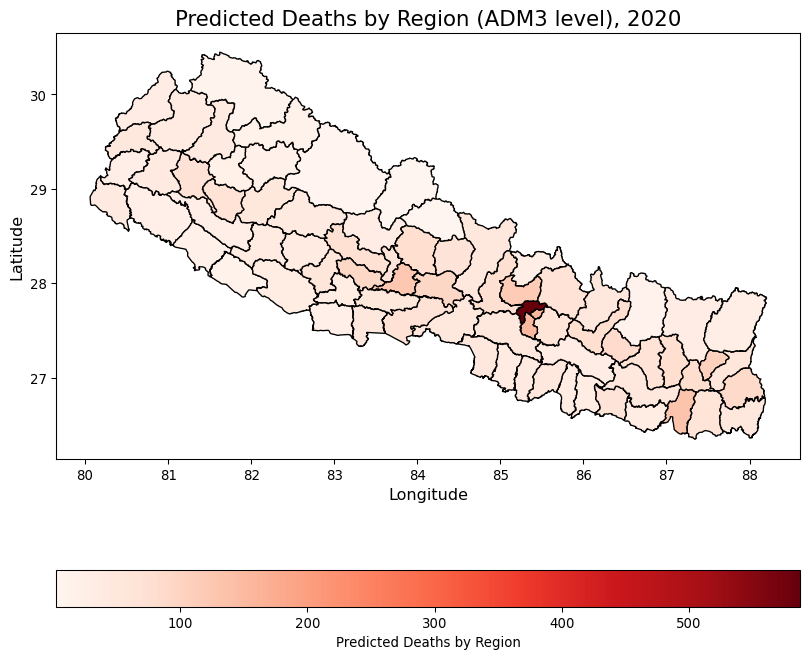

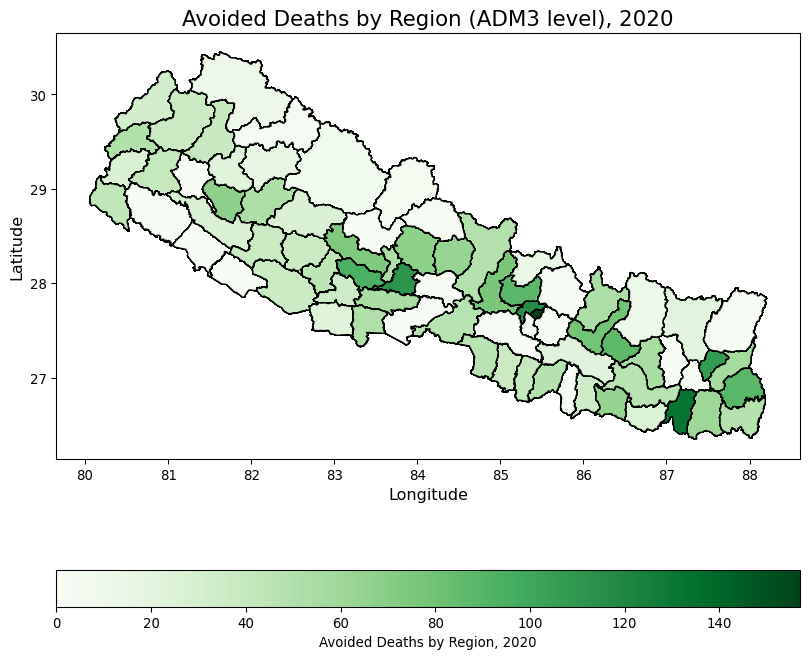

In [14]:
# Now use data calculated with no forests
panel_df = pd.DataFrame(panel_noforest_gdf)
panel_df['deaths'] = panel_df['Total Deaths']

# Log-transform the independent variables
panel_df['ln_avg_sed_exp'] = panel_df['avg_sed_exp'].apply(lambda x: np.log(x) if x > 0 else np.nan)
panel_df['ln_pop_mean'] = panel_df['pop_mean'].apply(lambda x: np.log(x) if x > 0 else np.nan)

# Predict the outcome (deaths) using the new dataset
predictions = model.predict(panel_df[panel_df['year'] == 2020])
panel_df['predicted_deaths'] = predictions
panel_df['avoided_deaths'] = np.where(
    panel_df['predicted_deaths'] - panel_df['deaths'] > 0, 
    panel_df['predicted_deaths'] - panel_df['deaths'],
    0)

# Plot Predicted Deaths 2020
panel_gdf = gpd.GeoDataFrame(panel_df, geometry='geometry')
fig, ax = plt.subplots(figsize=(10, 10))
panel_gdf.plot(column='predicted_deaths', ax=ax, legend=True,
                             legend_kwds={'label': "Predicted Deaths by Region",
                                          'orientation': "horizontal"},
                             edgecolor='black', cmap='Reds')
ax.set_title("Predicted Deaths by Region (ADM3 level), 2020", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)
plt.show()

# Plot Avoided Deaths 2020
fig, ax = plt.subplots(figsize=(10, 10))
panel_gdf.plot(column='avoided_deaths', ax=ax, legend=True,
                             legend_kwds={'label': "Avoided Deaths by Region, 2020",
                                          'orientation': "horizontal"},
                             edgecolor='black', cmap='Greens')
ax.set_title("Avoided Deaths by Region (ADM3 level), 2020", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)
plt.show()

## Conclusion

This project demonstrates a method for estimating the current value of
landslide regulation provided by forests in Nepal. By focusing solely on
mortality, this approach likely represents a lower bound, as it does not
account for damages to property or infrastructure. Given that the method
relies on data with global coverage, it has the potential to be applied
universally, enabling the calculation of landslide regulation values for
countries worldwide.

## References

Brander, L. M., Tankha, S., Sovann, C., Sanadiradze, G., Zazanashvili,
N., Kharazishvili, D., … & Arobelidze, N. (2018). Mapping the economic
value of landslide regulation by forests. Ecosystem Services, 32,
101-109.

Sharp, R., Douglass, J., Wolny, S., Arkema, K., Bernhardt, J.,
Bierbower, W., … & Wyatt, K. (2020). InVEST 3.8. 7. User’s Guide. The
Natural Capital Project.